# Evaluating Logistic Regression Predictions

In [1]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [2]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
import seaborn as sns

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_18020/25620917.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### In this workbook I will evaluate my model for determining if a tree is "tall" or not (tall meaning "height higher than 10m") using a dataset of trees in Amsterdam.

In [3]:
df = pd.read_csv('data/clean_tree_data.csv')

### Part a): Data Cleaning & Exploration

#### I will apply the same process as the two last workbooks to my data.

In [4]:
# Load tree data
df = pd.read_csv('data/clean_tree_data.csv')
# the dataset is much bigger than we need, sampling from it
data_n = 2000
df = df.sample(data_n, random_state=31415)

# taller than 10m is a positive outcome otherwise negative
df['is_tall'] = pd.Series(df['tree_height_fixed'] > 10).astype(int)
Y = df['is_tall']

# streamline tree treatment for efficiency
df['growing_freely'] = pd.Series(
    df['tree_treatment'] == 'Boom vrij uitgroeiend'
).astype(int)

# too many tree genuses is breaking my model so I'll keep the most common genuses
# and qualify all the other ones as "other"
most_common_n = 5
most_common_genuses = df['species_group'].value_counts().iloc[:most_common_n].index
def otherise_genus(genus):
    if genus in most_common_genuses:
        return genus
    else: 
        return "other"

df['species_group'] = df['species_group'].apply(lambda x: otherise_genus(x))

# Create design matrix 
X = pd.DataFrame({
    'diameter': df['diameter'],
    'age': df['age'],
    'growing_freely': df['growing_freely'],
})

# dummy variables
categorical_vars = ['species_group']

# if I need to refer to each dummy column of a category I can use this dict
indexed_dummy_columns = dict()

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    indexed_dummy_columns[category] = dummies.columns
    X = pd.concat([X, dummies], axis=1)

X_with_intercept = sm.add_constant(X)
X_with_intercept.dropna(inplace=True)


#### vii. Calculate the correlation matrix across the outcome and X. 

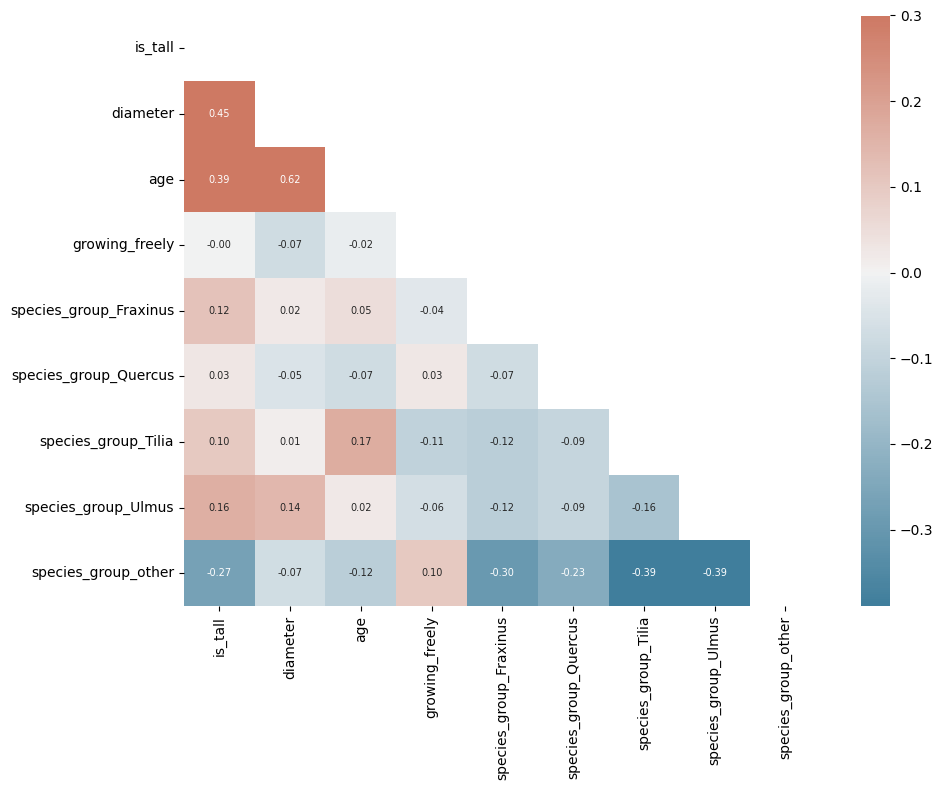

In [5]:
# Add is_tall as the first column in X to create a combined DataFrame YX
X['is_tall'] = df['is_tall']
YX = X[['is_tall'] + [c for c in X.columns if c != 'is_tall']]  # Ensure is_tall is the first column

# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

### Part b): Model Assessment and Selection

#### i. Set up the full design matrix X, this time include the states_matrix, and a constant. 
#### Finally bind the outcome to it and ensure it's the first column of the resulting dataframe. 

In [6]:
# Design matrix
# X_with_intercept is our full design matrix already with a constant

# Get full dataset together 
YX_const =  pd.concat([Y ,X_with_intercept], axis=1)

#### ii. Create a validation set (75%) and test set (25%). 
#### Ensure the rows of the full dataset selected for each set are chosen at random. 

In [7]:
# Split data into validation and test (75:25)

valid_frac = 0.75

def get_sets(YX, valid_frac):
    shuffled = YX.sample(frac=1, random_state=42)
    total_size = len(shuffled.index)
    valid_size = int(total_size * valid_frac)
    # validation set
    YX_valid = shuffled.iloc[:valid_size]
    # remainder becomes the test set
    YX_test = shuffled.iloc[valid_size:]
    return YX_valid, YX_test



# Subset to create validation and test
YX_const_val, YX_const_test = get_sets(YX_const, valid_frac)

#### iii. Using a dictionary, define three candidate models in terms of the columns of the design matrix involved in each. 
#### The first model should be the homogeneous probability model; the second should  have all covariates except the species; the third should use all the columns. 


In [8]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': ['const', 'diameter', 'age', 'growing_freely'],
    'c': X_with_intercept.columns.tolist()
}

In [9]:
model = sm.Logit(Y, X_with_intercept).fit(maxiter=1000,method='bfgs',disp=0)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_tall   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            8
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.3260
Time:                        14:07:36   Log-Likelihood:                -843.46
converged:                       True   LL-Null:                       -1251.5
Covariance Type:            nonrobust   LLR p-value:                7.273e-171
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.4939      0.248    -10.048      0.000      -2.980      -2.007
diameter                  11.8019      0.848     13.925      0.000      10.141      13.463
age                        0.0089      0.005      1.740      0.082      -0.001       0.019
growing_freely             0.5868      0.208      2.820      0.005       0.179       0.995
species_group_Fraxinus     0.9828      0.306      3.213      0.001       0.383       1.582
species_group_Quercus      0.6092      0.306      1.992      0.046       0.010       1.209
species_group_Tilia        0.2143      0.252      0.849      0.396      -0.281       0.709
species_group_Ulmus        1.0453      0.274      3.818      0.000       0.509       1.582
species_group_other       -0.6221      0.195     -3.185      0.001      -1.005      -0.239
==========================================================================================
"""

#### iv. Pick a metric (or more) on which you want to compare these models. Using cross-validation on the validation set, compare the models and select one you wish to deploy. 

In [10]:
y = YX_const_val['is_tall'] # Target variable

# Define K for cross validation
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}

# Initialize dictionaries to store scores (e.g. Brier score)
brier_scores = {key: [] for key in predictors}

for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_const_val):
        
        # Split into train and test according to the folds 
        X_train, X_test = YX_const_val.iloc[train_index][cols], YX_const_val.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit(maxiter=1000,method='bfgs',disp=0) 
                
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Metric (e.g. Brier score)
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # (If you pick a classification metric, you have to use a decision threshold)
        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)
        
        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)

        
        aic_scores[key].append(model.aic)

        # print(model.summary())

        
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    average_accuracy = np.mean(acc_scores[key])
    average_balanced_accuracy = np.mean(balanced_acc_scores[key])
    average_aic = np.mean(aic_scores[key])
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average accuracy': average_accuracy,
        'Average balanced accuracy': average_balanced_accuracy,
        'AIC': average_aic,
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
display(results_df)
print(f'Null information rate: {np.mean(YX_const['is_tall'])}')

,Model,Average Brier Score,Average accuracy,Average balanced accuracy,AIC
0,a,0.21812,0.67933,0.50000,1507.51872
1,b,0.14225,0.81067,0.78831,1072.50303
2,c,0.13483,0.80000,0.75696,1013.45988


Null information rate: 0.6815


#### v. Re-fit the selected model to the full validation set. 

In [11]:
# Pick model C. Its got slightly less balanced accuracy but its AIC is lower.
# Now fit the model to the full validation set
model = sm.Logit(YX_const_val['is_tall'], YX_const_val[predictors['c']]).fit()

Optimization terminated successfully.
         Current function value: 0.415459
         Iterations 8


In [12]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                is_tall   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1491
Method:                           MLE   Df Model:                            8
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.3378
Time:                        14:07:38   Log-Likelihood:                -623.19
converged:                       True   LL-Null:                       -941.06
Covariance Type:            nonrobust   LLR p-value:                4.832e-132
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.5297      0.287     -8.810      0.000      -3.092      -1.967
diameter                  12.2113      1.007     12.121      0.000      10.237      14.186
age 

### Part c): Model Evaluation and Estimation of Generalisation Error

#### i. Generate 1000 simulations of the regression coefficients by sampling from the empirical posterior distribution. 

In [13]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

#### ii.  For each simulation, generate a predicted probability for the test-set conspiracy assessments. 

In [14]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_const_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_const_test[predictors['c']], beta_simulation)
    probabilities = logistic_sigmoid(log_odds)   # Convert log-odds to probabilities
    predictions[i] = probabilities

In [15]:
YX_const_test

,is_tall,const,diameter,age,growing_freely,species_group_Fraxinus,species_group_Quercus,species_group_Tilia,species_group_Ulmus,species_group_other
11585,1,1.00000,0.40000,39.00000,0,0.00000,0.00000,0.00000,1.00000,0.00000
14835,0,1.00000,0.25000,28.00000,0,0.00000,0.00000,0.00000,0.00000,1.00000
3816,0,1.00000,0.15000,17.00000,0,0.00000,0.00000,0.00000,0.00000,1.00000
3149,1,1.00000,0.75000,18.00000,0,0.00000,0.00000,0.00000,1.00000,0.00000
2992,1,1.00000,0.15000,17.00000,0,0.00000,0.00000,0.00000,0.00000,1.00000
...,...,...,...,...,...,...,...,...,...,...
12376,1,1.00000,0.15000,19.00000,0,0.00000,0.00000,0.00000,1.00000,0.00000
17268,0,1.00000,0.15000,24.00000,0,0.00000,0.00000,0.00000,0.00000,1.00000
23456,1,1.00000,0.40000,40.00000,0,0.00000,0.00000,1.00000,0.00000,0.00000
3805,0,1.00000,0.25000,41.00000,0,1.00000,0.00000,0.00000,0.00000,0.00000


In [16]:
predictions

array([[0.97832, 0.514  , 0.2006 , ..., 0.96096, 0.84825, 0.84202],
       [0.98556, 0.51965, 0.19012, ..., 0.96781, 0.9218 , 0.87878],
       [0.97824, 0.51933, 0.21839, ..., 0.94233, 0.84213, 0.86668],
       ...,
       [0.97252, 0.49623, 0.22863, ..., 0.94617, 0.84214, 0.85824],
       [0.98403, 0.54531, 0.20985, ..., 0.95456, 0.85301, 0.87156],
       [0.97584, 0.5366 , 0.23035, ..., 0.94641, 0.83536, 0.85404]])

#### iii.  For the first 20 assessments in the test-set, plot the posterior distirbution of the probabilities.
#### Highlight whether the density of each lies above or below a given `threshold` for classification. 

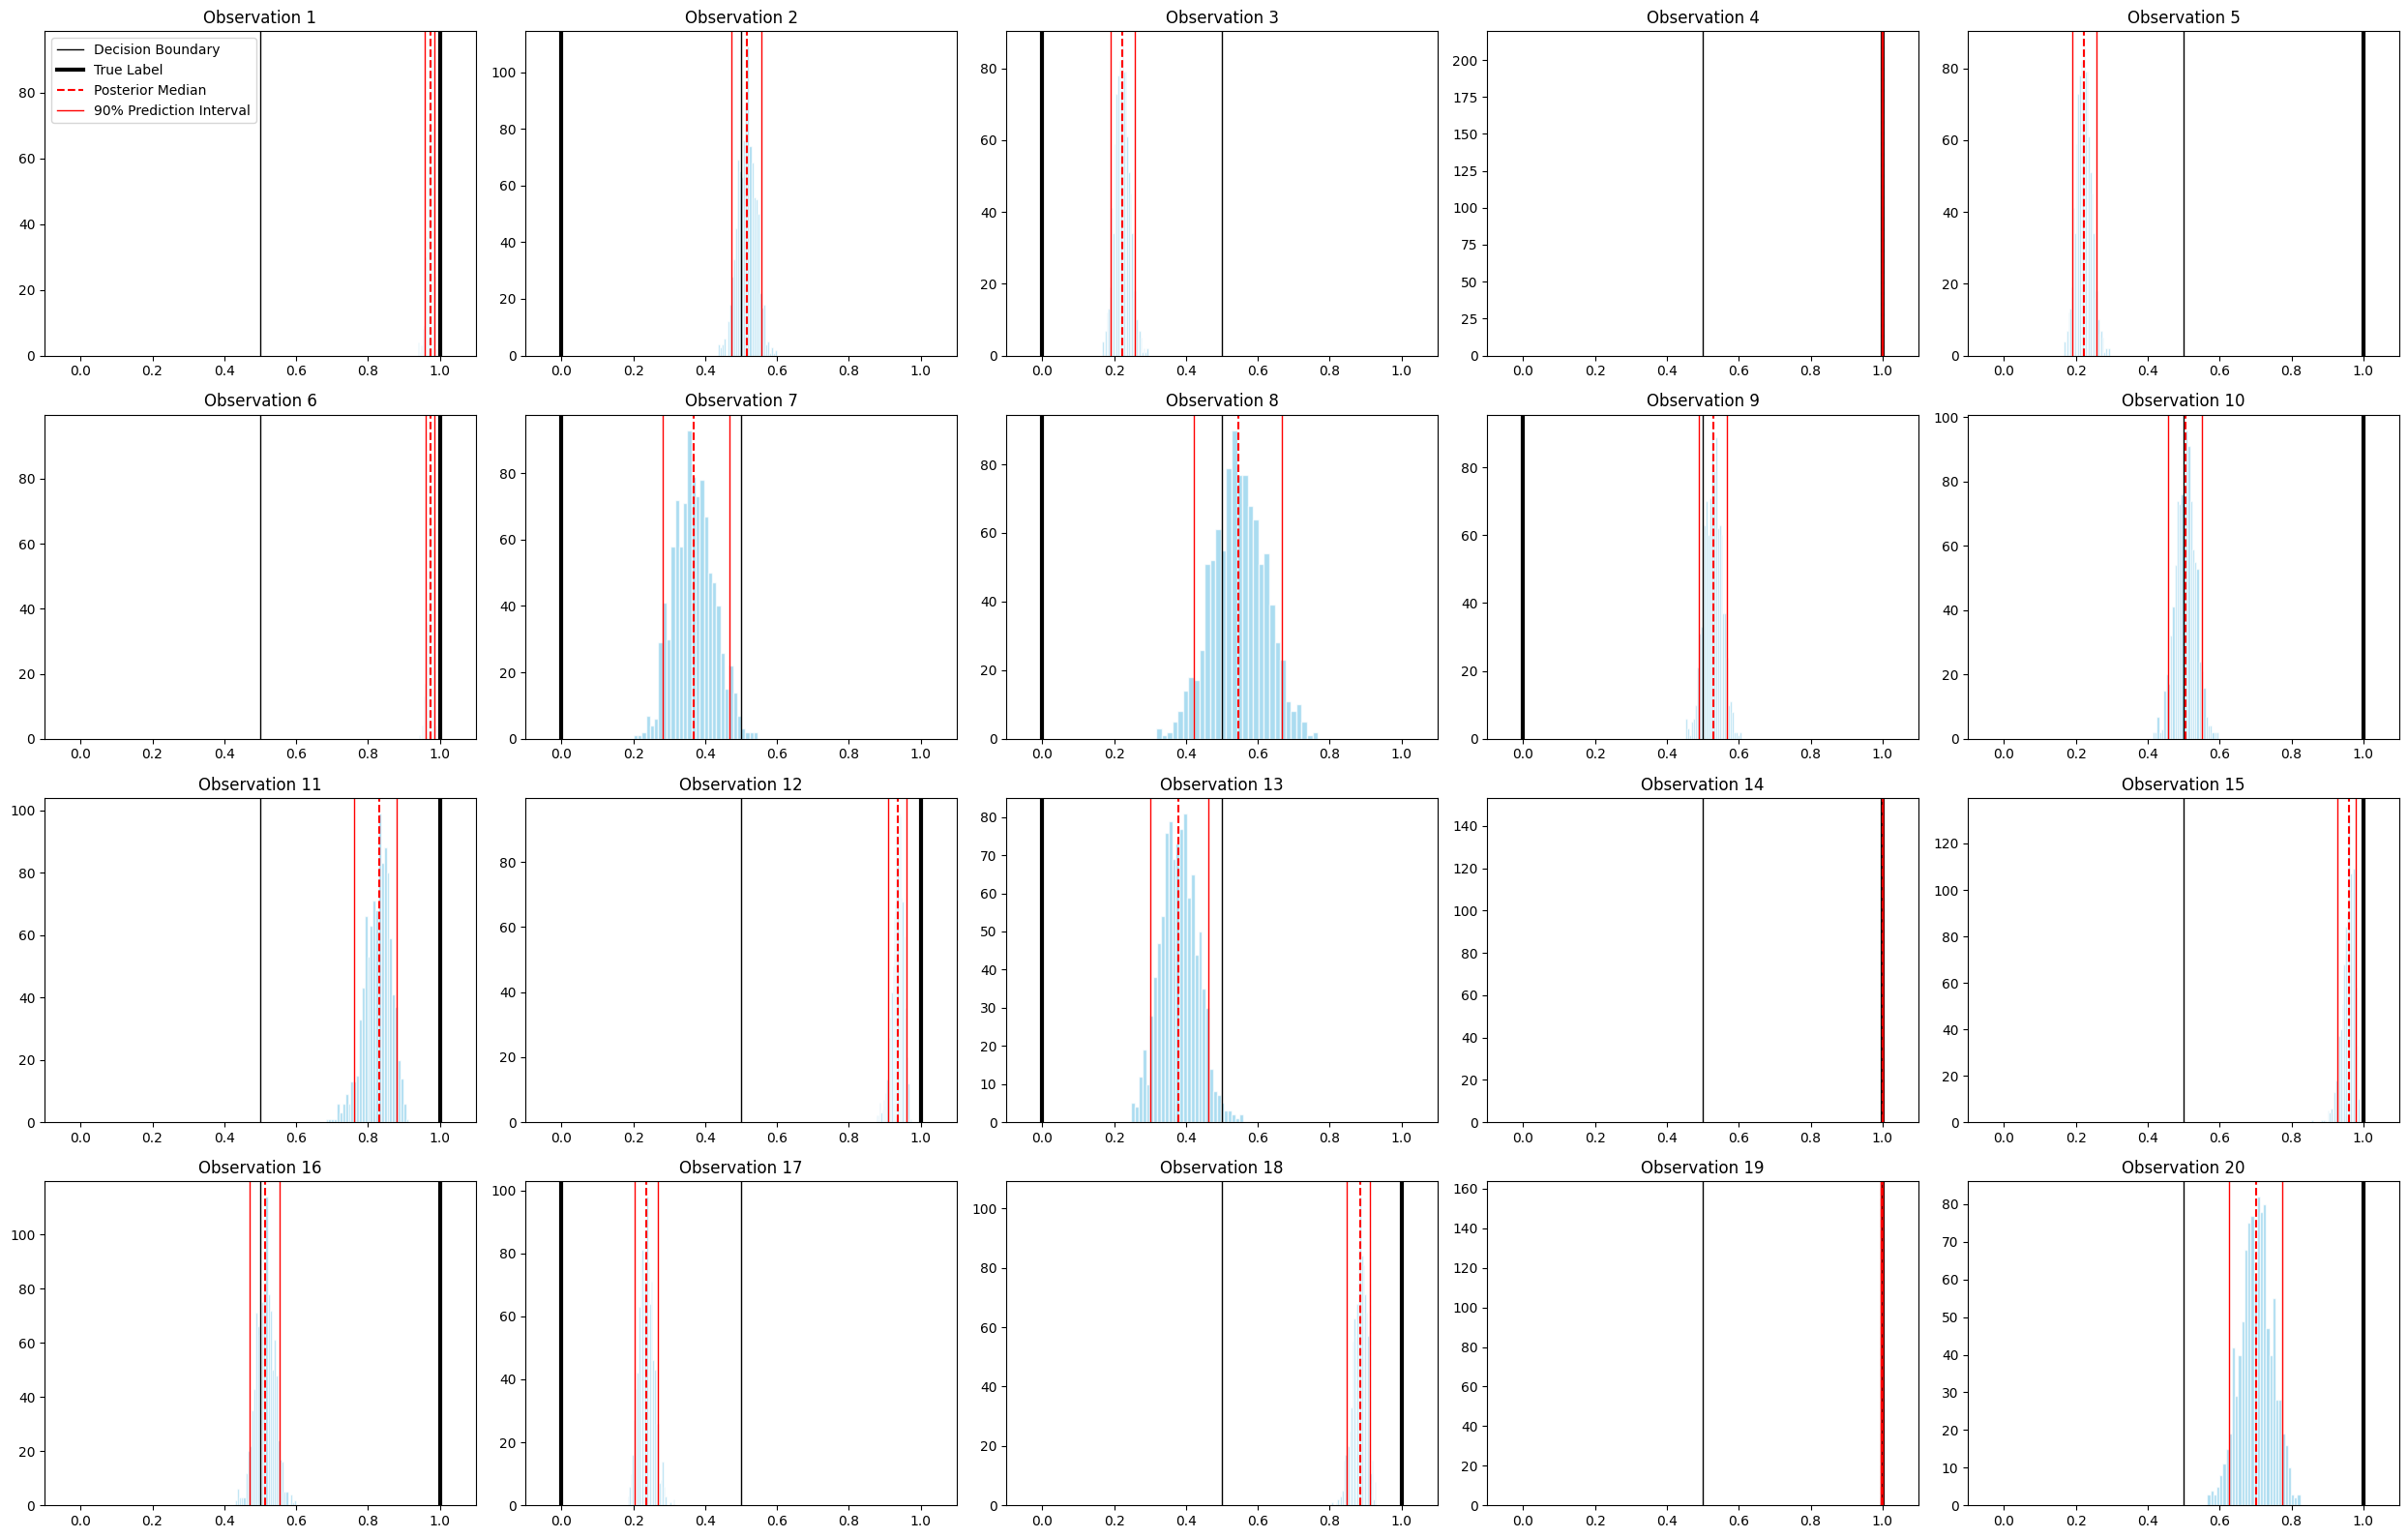

In [17]:
true_labels = YX_const_test['is_tall']

# Calculate posterior median and the 90% prediction interval for each of the first 10 observations
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

#### v. Simulate classes (1s or 0s) for the test-set of tree tallness, from the posterior predictive distirbution. 

In [18]:
# Simulate from the posterior-predictive distribution 
simulated_outcomes = np.random.binomial(1, predictions)

#### vi. Calculate the generalisation error for Classification. 
#### You can choose any classification error metric you wish (i.e. any metric from the confusion matrix). The most basic metric we might be interested about is just `accuracy`. 

#### Hint: We have 1000 simulated predicted classes. For each of those 1000 sets of simulations of the test-set labels, you need to calculate the accuracy. Then you have to plot the histogram of the accuracies. 

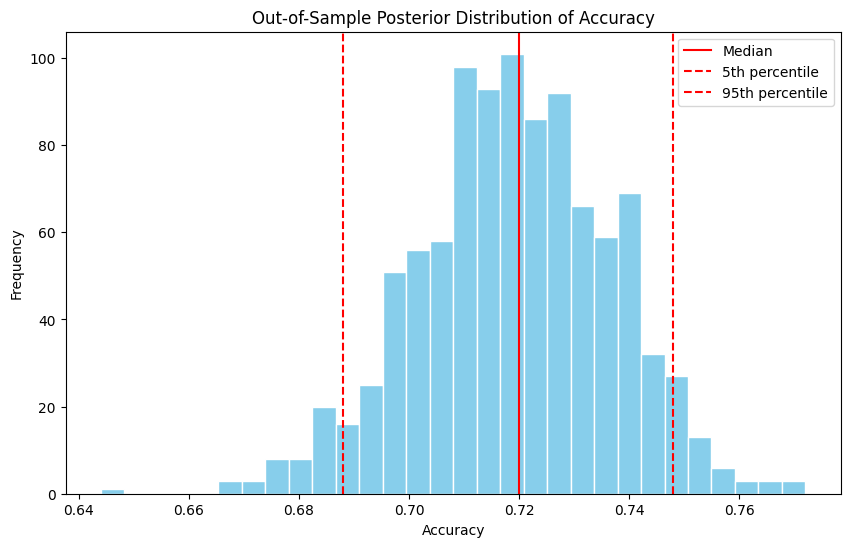

In [19]:
# Calculate accuracy for each simulation
# we didn't have a huge discrepency between accuracy and balanced accuracy so
# I'll stick to accuracy
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))


# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

With a median of 0.72 and a 90 percentile between 0.69 and 0.76, we have a model that's only slightly better than the no-information rate which is 0.68.

